### OOS
Goal: Complete OOS analysis based on output from previous IS analysis

##### Import standard libraries

In [1]:
# Import standard libs
%matplotlib inline

import pandas as pd
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pylab as plt
from pandas.tseries.offsets import BDay
import os
import os.path
import pickle
import random
import json

from sklearn.model_selection import StratifiedShuffleSplit, TimeSeriesSplit
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

##### Import custom libraries

In [2]:
# Imports and assignments
from Code.lib.plot_utils import PlotUtility
from Code.lib.time_utils import TimeUtility
from Code.lib.retrieve_data import DataRetrieve, ComputeTarget
from Code.lib.candle_indicators import CandleIndicators
from Code.lib.transformers import Transformers
from Code.lib.ta_momentum_studies import TALibMomentumStudies
from Code.lib.model_utils import ModelUtility, TimeSeriesSplitImproved
from Code.lib.feature_generator import FeatureGenerator
from Code.utilities.stat_tests import stationarity_tests
from Code.lib.config import current_feature, feature_dict
from Code.models import models_utils
from Code.lib.model_algos import AlgoUtility

plotIt = PlotUtility()
timeUtil = TimeUtility()
ct = ComputeTarget()
candle_ind = CandleIndicators()
dSet = DataRetrieve()
taLibMomSt = TALibMomentumStudies()
transf = Transformers()
modelUtil = ModelUtility()
featureGen = FeatureGenerator()
dSet = DataRetrieve()
modelAlgo = AlgoUtility()

In [3]:
# function to create system directory based on system name if one doesn't already exist
def get_system_dir(system_name):
    # Create system directory in current path
    current_directory = os.getcwd()
    system_directory = os.path.join(current_directory, system_name)
    if not os.path.exists(system_directory):
       os.makedirs(system_directory)
    return system_directory

In [4]:
# functions for save and load json files
def save_json(filename, json_file):
    # Save system_dict to file
    #filename = 'system_dict.json'
    file_path = os.path.join(system_directory, filename)
    with open(file_path, 'w') as fp:
        json.dump(json_file, fp, sort_keys=True, indent=4)
        
def load_json(file_path):
    with open(file_path, 'r') as fp:
        json_file = json.load(fp)
    return json_file

#### Get system information from IS
Where to start?
Manually?


In [5]:
system_name = 'TLT-Long-system-7045-V1'

In [6]:
# Get info from system_dict
current_directory = os.getcwd()
system_directory = os.path.join(current_directory, system_name)
if not os.path.exists(system_directory):
    print("system doesn't exist")
else:
    filename = 'system_dict.json'    
    file_path = os.path.join(system_directory, filename)
    system_dict = load_json(file_path)
    issue = system_dict["issue"]
    direction = system_dict["direction"]
    ver_num = system_dict["ver_num"]
    # Perhaps only load these when needed?
    pivotDate = system_dict["pivot_date"]
    is_oos_ratio = system_dict["is_oos_ratio"]
    oos_months = system_dict["oos_months"]
    segments = system_dict["segments"]

#### Retrieve data

In [7]:
# retrieve dataset from IS
print(system_directory)
print(system_name)
file_title = "raw-features-" + system_name + ".pkl"
file_name = os.path.join(system_directory, file_title)
dataSet = pd.read_pickle(file_name)

C:\Users\kruegkj\Documents\GitHub\QuantTradingSys\Code\notebooks\TLT-Long-system-7045-V1
TLT-Long-system-7045-V1


In [8]:
dataSet.head(5)

,Open,High,Low,Close,AdjClose,Volume,gainAhead,beLong,PPO_f2_s5,PPO_f2_s5_Normalized,...,ROC_10_Normalized,Close_lag3,Close_lag3_Normalized,Close_lag5,Close_lag5_Normalized,ChaikinADOSC_f4_s10,ChaikinADOSC_f4_s10_Normalized,KAMA_4,KAMA_4_Normalized,Volume_Normalized
2002-11-07,87.05,87.73,86.85,87.73,48.2867,147900.0,0.008093,1,0.734559,0.850939,...,0.658536,88.41,0.781192,86.76,0.503464,156663.768769,0.751232,85.944019,0.206014,0.521408
2002-11-08,88.40,88.65,87.95,88.44,48.6775,294700.0,0.005427,1,1.797065,0.948797,...,0.689196,88.60,0.806426,87.11,0.583669,180784.851739,0.782884,86.707639,0.427486,0.802277
2002-11-11,88.55,88.92,88.40,88.92,48.9417,70000.0,-0.005735,-1,1.704246,0.933679,...,0.734183,86.76,0.502790,87.50,0.668962,194750.848707,0.800093,87.690911,0.738316,0.356152
2002-11-12,89.15,89.15,88.37,88.41,48.6610,494300.0,0.002149,1,0.959896,0.824649,...,0.604911,87.11,0.567559,87.82,0.733123,90657.171508,0.653535,87.874938,0.785763,0.973333
2002-11-13,88.45,88.69,87.96,88.60,48.7656,104700.0,-0.020767,-1,0.096132,0.494370,...,0.623113,87.50,0.637574,86.96,0.549523,50174.349132,0.587458,87.959594,0.805790,0.428346


#### Retrieve feature_dict

In [9]:
file_name = 'feature_dict.json'
file_path = os.path.join(system_directory, file_name)
feature_dict = load_json(file_path)

In [10]:
feature_dict

{'CCI_10': 'Drop',
 'CCI_10_Normalized': 'Drop',
 'CMO_5': 'Drop',
 'CMO_5_Normalized': 'Drop',
 'ChaikinADOSC_f4_s10': 'Drop',
 'ChaikinADOSC_f4_s10_Normalized': 'Keep',
 'Close_lag3': 'Drop',
 'Close_lag3_Normalized': 'Keep',
 'Close_lag5': 'Drop',
 'Close_lag5_Normalized': 'Keep',
 'KAMA_4': 'Drop',
 'KAMA_4_Normalized': 'Drop',
 'PPO_f2_s5': 'Drop',
 'PPO_f2_s5_Normalized': 'Keep',
 'ROC_10': 'Drop',
 'ROC_10_Normalized': 'Keep',
 'RSI_2': 'Drop',
 'RSI_2_Normalized': 'Keep',
 'UltOsc_t110_t220_t330': 'Drop',
 'UltOsc_t110_t220_t330_Normalized': 'Keep',
 'Volume_Normalized': 'Keep'}

### Establish and display OOS time parameters

In [11]:
# Set IS-OOS parameters
from datetime import datetime
pivotDate = datetime.strptime(pivotDate, '%Y-%m-%d')
print(pivotDate)

2019-01-03 00:00:00


In [12]:
pivotDate = datetime.date(pivotDate)

In [13]:
# set date splits
isOosDates = timeUtil.is_oos_data_split(issue, pivotDate, is_oos_ratio, oos_months, segments)
dataLoadStartDate = isOosDates[0]
is_start_date = isOosDates[1]
oos_start_date = isOosDates[2]
is_months = isOosDates[3]
is_end_date = isOosDates[4]
oos_end_date = isOosDates[5]

modelStartDate = oos_start_date
modelEndDate = modelStartDate + relativedelta(months=oos_months)
print("Issue: " + issue)
print("OOS Start date: " + str(modelStartDate) + "  OOS End date: " + str(modelEndDate))

                    Segments:  1
                IS OOS Ratio:  4
                  OOS months:  4
                   IS Months:  16
              Months to load:  20
              Data Load Date:  2017-04-03
              IS Start  Date:  2017-05-03
              OOS Start Date:  2018-09-03
                  Pivot Date:  2019-01-03
Issue: TLT
OOS Start date: 2018-09-03  OOS End date: 2019-01-03


### Retrieve best model
Where am I getting model name?
Should come from system_dict (or some dict)
For now, hard code

In [14]:
best_model_name = system_dict["best_model"]
file_title = "fit-model-" + best_model_name + "-IS-" + system_name + ".sav"
file_name = os.path.join(system_directory, file_title)
model = pickle.load(open(file_name, 'rb'))

### Initialize dataframes for trade analysis
    

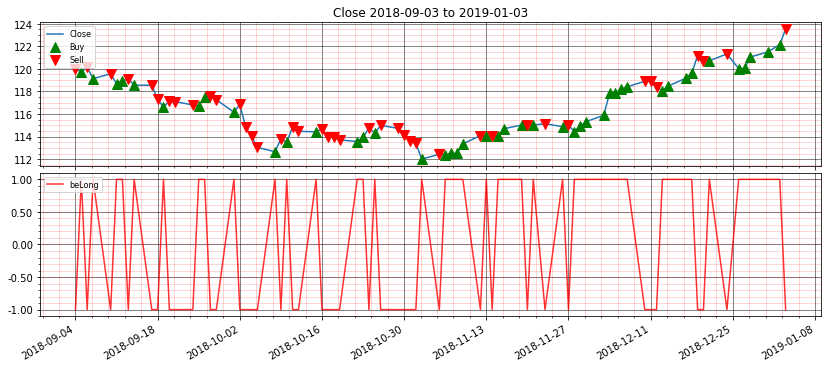

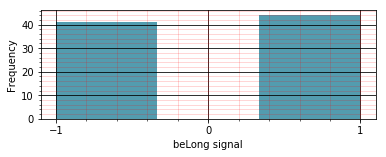

In [16]:
tradesDataFull = pd.DataFrame()
valDataFull = pd.DataFrame()

valData = dataSet[modelStartDate:modelEndDate].copy()
tradesData = valData.copy()

# Plot price and be lOngs for visual analysis
models_utils.plotPriceAndBeLong(issue,
                                modelStartDate,
                                modelEndDate,
                                valData
                                )

In [17]:
# drop cols
col_vals = [k for k,v in feature_dict.items() if v == 'Drop']
to_drop = ['Open','High','Low', 'gainAhead', 'Close', 'Volume', 'AdjClose', 'beLong']
for x in to_drop:
    col_vals.append(x)
valModelData = dSet.drop_columns(valData, col_vals)

valRows = valModelData.shape[0]
#        print("There are %i data points" % valRows)

In [18]:
valModelData.head(5)

,PPO_f2_s5_Normalized,RSI_2_Normalized,UltOsc_t110_t220_t330_Normalized,ROC_10_Normalized,Close_lag3_Normalized,Close_lag5_Normalized,ChaikinADOSC_f4_s10_Normalized,Volume_Normalized
2018-09-04,0.013658,0.086060,0.279866,0.057872,0.049884,0.039310,0.747351,1.000000
2018-09-05,0.007195,0.137057,0.271397,0.063233,0.107233,0.066807,0.735571,0.908454
2018-09-06,0.094788,0.400100,0.276884,0.061067,0.039310,0.112342,0.760876,0.917348
2018-09-07,0.174278,0.185423,0.134142,0.014472,0.066807,0.088748,0.672838,0.963717
2018-09-10,0.198679,0.435138,0.102232,0.032856,0.112342,0.114775,0.691928,0.536440


In [19]:
# test the validation data
y_validate = []
y_validate = model.predict(valModelData)

### Establish best estimate of trades

In [20]:
# Create best estimate of trades
bestEstimate = np.zeros(valRows)

# You may need to adjust for the first and / or final entry 
for i in range(valRows -1):
    #print(valData.gainAhead.iloc[i], y_validate[i])
    if y_validate[i] > 0.0: 
        bestEstimate[i] = valData.gainAhead.iloc[i]
    else:
        bestEstimate[i] = 0.0 

### Create and plot equity curve

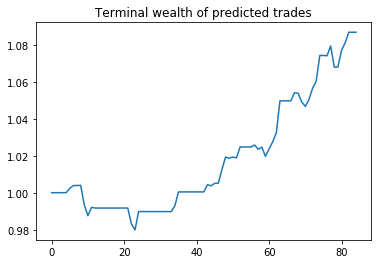

Terminal Weatlh:  1.09


In [21]:
# Plot equity curve
equity = np.zeros(valRows)
equity[0] = 1.0
for i in range(1,valRows):
    equity[i] = (1+bestEstimate[i])*equity[i-1]       
plt.plot(equity)
plt.title('Terminal wealth of predicted trades')
plt.show(block=True)

print('{0:} {1:.2f}'.format("Terminal Weatlh: ", equity[valRows-1]))

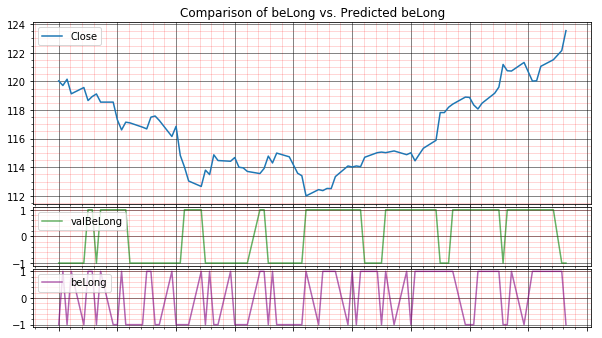

In [22]:
# Store predictions in valBeLong for plotting
valData['valBeLong'] = pd.Series(y_validate, index=valData.index)

# Plot price and trading signals
models_utils.plotPriceAndTradeSignals(valData)

### Storing info for later trades analysis 

In [23]:
tradesData['valBeLong'] = pd.Series(y_validate, index=tradesData.index)
tradesData['gain'] = tradesData['Close'] - tradesData['Open']



Starting Equity Analysis

There are 85 rows of data
TWR for All is 1.02044518568
TWR for BeLong is 1.22134445109
TWR for ValBeLong is 1.08677367523


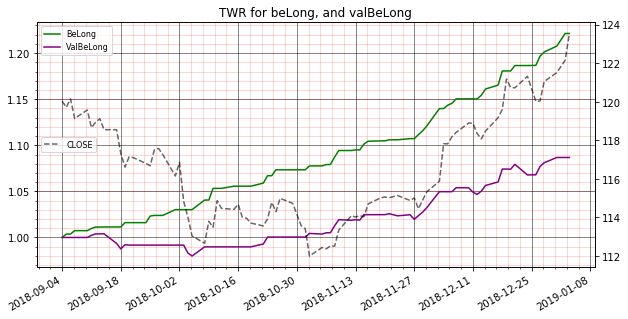

In [24]:
# Getting Cumulative equity values
#  Count the number of rows in the file
print('\n\nStarting Equity Analysis\n')
nrows = tradesData.shape[0]
print ('There are %0.f rows of data' % nrows)

models_utils.cumulEquity(valData, tradesData, ceType='All')  
models_utils.cumulEquity(valData, tradesData, ceType='BeLong')   
models_utils.cumulEquity(valData, tradesData, ceType='ValBeLong')
# Plot those values
models_utils.plotPriceAndCumulEquity(issue, valData)

### Trades Analysis

#### Initialize vars for trade analysis

In [25]:
tradesDataFull = tradesDataFull.append(tradesData)
valDataFull = valDataFull.append(valData)

ndays = tradesDataFull.shape[0]
ndays

85

In [26]:
#  Local variables for trading system    
initialEquity = 100000
fixedTradeDollars = 10000
commission = 0.005      #  Dollars per share per trade

#  These are scalar and apply to the current conditions      
entryPrice = 0
exitPrice = 0

#  These have an element for each day loaded
#  Some will be unnecessary    
accountBalance = np.zeros(ndays)
cash = np.zeros(ndays)
sharesHeld = np.zeros(ndays)
tradeGain = []
tradeGainDollars = []
openTradeEquity = np.zeros(ndays)
tradeWinsValue = np.zeros(ndays)
tradeLossesValue = np.zeros(ndays)

iTradeDay = 0
iTradeNumber = 0

#  Day 0 contains the initial values
accountBalance[0] = initialEquity
cash[0] = accountBalance[0]
sharesHeld[0] = 0

####  Loop over all the days loaded

In [27]:
# Loop over all days loaded
oos_start_date = isOosDates[2]
oos_end_date = isOosDates[5]

for i in range (1,ndays):
    #  Extract the date
    dt = tradesDataFull.index[i]
    dt = dt.date()
    #  Check the date
    # oos_start_date
    # oos_end_date
    datesPass = dt>=oos_start_date and dt<=pivotDate
    if datesPass:
        iTradeDay = iTradeDay + 1
        if sharesHeld[iTradeDay-1] > 0:
            #  In a long position
            if tradesDataFull.valBeLong[i]<0:
                #  target is -1 -- beFlat 
                #  Exit -- close the trade
                exitPrice = tradesDataFull.Close[i]
                grossProceeds = sharesHeld[iTradeDay-1] * exitPrice
                commissionAmount = sharesHeld[iTradeDay-1] * commission
                netProceeds = grossProceeds - commissionAmount
                #print("netProceeds: ", netProceeds)
                cash[iTradeDay] = cash[iTradeDay-1] + netProceeds
                accountBalance[iTradeDay] = cash[iTradeDay]
                sharesHeld[iTradeDay] = 0
                iTradeNumber = iTradeNumber+1
                #tradeGain[iTradeNumber] = (exitPrice / (1.0 * entryPrice))    
                tradeGain.append(exitPrice / (1.0 * entryPrice))
                tradeGainDollars.append(((exitPrice / (1.0 * entryPrice))*fixedTradeDollars)-fixedTradeDollars)

                pass
            else:
                #  target is +1 -- beLong
                #  Continue long
                sharesHeld[iTradeDay] = sharesHeld[iTradeDay-1]
                cash[iTradeDay] = cash[iTradeDay-1]
                MTMPrice = tradesDataFull.Close[i]
                openTradeEquity = sharesHeld[iTradeDay] * MTMPrice
                accountBalance[iTradeDay] = cash[iTradeDay] + openTradeEquity
                pass
        else:
            #  Currently flat
            if tradesDataFull.valBeLong[i]>0:
                #  target is +1 -- beLong
                #  Enter a new position
                entryPrice = tradesDataFull.Close[i]
                sharesHeld[iTradeDay] = int(fixedTradeDollars/(entryPrice+commission))
                shareCost = sharesHeld[iTradeDay]*(entryPrice+commission)
                cash[iTradeDay] = cash[iTradeDay-1] - shareCost
                openTradeEquity = sharesHeld[iTradeDay]*entryPrice
                accountBalance[iTradeDay] = cash[iTradeDay] + openTradeEquity
                pass
            else:
                #  target is -1 -- beFlat
                #  Continue flat
                cash[iTradeDay] = cash[iTradeDay-1]
                accountBalance[iTradeDay] = cash[iTradeDay] 
                pass
    else:
        print("dates don't pass")

In [28]:
# Format and print results
finalAccountBalance = accountBalance[iTradeDay]
print ('Final account balance: %.2f' %  finalAccountBalance)
numberTradeDays = iTradeDay        
numberTrades = iTradeNumber
print ("Number of trades:", numberTrades)

Final account balance: 100827.62
Number of trades: 8


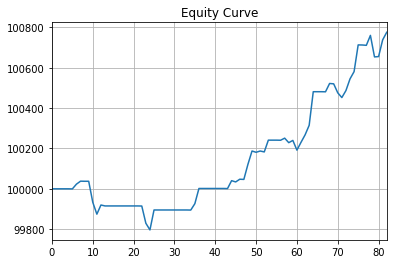

In [29]:
# Plot equity curve
from pandas import Series
    
Sequity = Series(accountBalance[0:numberTradeDays-1])
Sequity.plot(grid=True, title="Equity Curve", )
plt.show(block=False)

In [30]:
# Calculate trade statistics
tradeWins = sum(1 for x in tradeGain if float(x) >= 1.0)
tradeLosses = sum(1 for x in tradeGain if float(x) < 1.0 and float(x) > 0)
print("Wins: ", tradeWins)
print("Losses: ", tradeLosses)
print("W/L: ", tradeWins/numberTrades)

tradeWinsValue = sum((x*fixedTradeDollars)-fixedTradeDollars for x in tradeGain if float(x) >= 1.0)
tradeLossesValue = sum((x*fixedTradeDollars)-fixedTradeDollars for x in tradeGain if float(x) < 1.0 and float(x) > 0)
print('Total value of Wins:  %.2f' % tradeWinsValue)
print('Total value of Losses:  %.2f' % tradeLossesValue)
#(Win % x Average Win Size) – (Loss % x Average Loss Size)
print('Expectancy:  %.2f' % ((tradeWins/numberTrades)*(tradeWinsValue/tradeWins)-(tradeLosses/numberTrades)*(tradeLossesValue/tradeLosses)))
print("Fixed trade size: ", fixedTradeDollars)

Wins:  6
Losses:  2
W/L:  0.75
Total value of Wins:  981.42
Total value of Losses:  -141.61
Expectancy:  140.38
Fixed trade size:  10000


In [31]:
tradesDataFull.tail(5)

,Open,High,Low,Close,AdjClose,Volume,gainAhead,beLong,PPO_f2_s5,PPO_f2_s5_Normalized,...,Close_lag3_Normalized,Close_lag5,Close_lag5_Normalized,ChaikinADOSC_f4_s10,ChaikinADOSC_f4_s10_Normalized,KAMA_4,KAMA_4_Normalized,Volume_Normalized,valBeLong,gain
2018-12-27,121.26,121.38,119.9800,120.04,119.7679,12146772.0,0.008414,1,-0.446221,0.097180,...,0.901450,122.11,0.809991,-5.350915e+06,0.010307,120.353046,0.786044,0.856717,1,-1.22
2018-12-28,120.40,121.05,120.2900,121.05,120.7756,9879116.0,0.003800,1,-0.070463,0.242591,...,0.956843,121.75,0.760020,-4.474868e+06,0.047113,120.365251,0.762299,0.643356,1,0.65
2018-12-31,120.65,121.56,120.4600,121.51,121.2345,17408971.0,0.005267,1,0.407325,0.526133,...,0.809991,121.43,0.664462,-2.663441e+05,0.363018,120.377998,0.785343,0.990908,1,0.86
2019-01-02,121.66,122.16,121.3401,122.15,121.8731,19841527.0,0.011379,1,0.724242,0.713338,...,0.760020,121.24,0.585994,6.042490e+06,0.941620,121.165555,0.902842,0.996762,-1,0.49
2019-01-03,122.29,123.86,122.2267,123.54,123.2599,21187045.0,-0.011575,-1,0.975686,0.794186,...,0.664462,120.46,0.412070,1.151138e+07,0.999335,122.220864,0.970980,0.997688,-1,1.25


In [32]:
####  end and save Shadow trades  ####     
df_to_save = tradesDataFull[['valBeLong','gainAhead','Close']].copy()
df_to_save.reset_index(level=df_to_save.index.names, inplace=True)
df_to_save.columns=['Date','signal','gainAhead','Close']
#print(df_to_save)
filename = "OOS_Equity_" + system_name + ".csv"
df_to_save.to_csv(system_directory+ "\\" + filename, encoding='utf-8', index=False)


In [33]:
df_to_save.head(6)

,Date,signal,gainAhead,Close
0,2018-09-04,-1,-0.002666,120.03
1,2018-09-05,-1,0.003676,119.71
2,2018-09-06,-1,-0.008489,120.15
3,2018-09-07,-1,0.003693,119.13
4,2018-09-10,-1,-0.007611,119.57
5,2018-09-11,1,0.002360,118.66


In [34]:
df_to_save.tail(6)

,Date,signal,gainAhead,Close
79,2018-12-26,1,0.000167,120.02
80,2018-12-27,1,0.008414,120.04
81,2018-12-28,1,0.003800,121.05
82,2018-12-31,1,0.005267,121.51
83,2019-01-02,-1,0.011379,122.15
84,2019-01-03,-1,-0.011575,123.54


### Proceed to TMS Part 1